# Part 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from time import time
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

In [4]:
device

device(type='cuda')

## Data Loading

In [5]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=767c011214951e5b9b9e07c6964156a5cc5ed0c8e13cd7c02fdebd77b0dfb9d8
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [6]:
#from data_rnn import load_imdb

In [7]:
import wget, os, gzip, pickle, random, re, sys

IMDB_URL = 'http://dlvu.github.io/data/imdb.{}.pkl.gz'
IMDB_FILE = 'imdb.{}.pkl.gz'

PAD, START, END, UNK = '.pad', '.start', '.end', '.unk'

def load_imdb(final=False, val=5000, seed=0, voc=None, char=False):

    cst = 'char' if char else 'word'

    imdb_url = IMDB_URL.format(cst)
    imdb_file = IMDB_FILE.format(cst)

    if not os.path.exists(imdb_file):
        wget.download(imdb_url)

    with gzip.open(imdb_file) as file:
        sequences, labels, i2w, w2i = pickle.load(file)

    if voc is not None and voc < len(i2w):
        nw_sequences = {}

        i2w = i2w[:voc]
        w2i = {w: i for i, w in enumerate(i2w)}

        mx, unk = voc, w2i['.unk']
        for key, seqs in sequences.items():
            nw_sequences[key] = []
            for seq in seqs:
                seq = [s if s < mx else unk for s in seq]
                nw_sequences[key].append(seq)

        sequences = nw_sequences

    if final:
        return (sequences['train'], labels['train']), (sequences['test'], labels['test']), (i2w, w2i), 2

    # Make a validation split
    random.seed(seed)

    x_train, y_train = [], []
    x_val, y_val = [], []

    val_ind = set( random.sample(range(len(sequences['train'])), k=val) )
    for i, (s, l) in enumerate(zip(sequences['train'], labels['train'])):
        if i in val_ind:
            x_val.append(s)
            y_val.append(l)
        else:
            x_train.append(s)
            y_train.append(l)

    return (x_train, y_train), \
           (x_val, y_val), \
           (i2w, w2i), 2


def gen_sentence(sent, g):

    symb = '_[a-z]*'

    while True:

        match = re.search(symb, sent)
        if match is None:
            return sent

        s = match.span()
        sent = sent[:s[0]] + random.choice(g[sent[s[0]:s[1]]]) + sent[s[1]:]

def gen_dyck(p):
    open = 1
    sent = '('
    while open > 0:
        if random.random() < p:
            sent += '('
            open += 1
        else:
            sent += ')'
            open -= 1

    return sent

def gen_ndfa(p):

    word = random.choice(['abc!', 'uvw!', 'klm!'])

    s = ''
    while True:
        if random.random() < p:
            return 's' + s + 's'
        else:
            s+= word

def load_brackets(n=50_000, seed=0):
    return load_toy(n, char=True, seed=seed, name='dyck')

def load_ndfa(n=50_000, seed=0):
    return load_toy(n, char=True, seed=seed, name='ndfa')

def load_toy(n=50_000, char=True, seed=0, name='lang'):

    random.seed(0)

    if name == 'lang':
        sent = '_s'

        toy = {
            '_s': ['_s _adv', '_np _vp', '_np _vp _prep _np', '_np _vp ( _prep _np )', '_np _vp _con _s' , '_np _vp ( _con _s )'],
            '_adv': ['briefly', 'quickly', 'impatiently'],
            '_np': ['a _noun', 'the _noun', 'a _adj _noun', 'the _adj _noun'],
            '_prep': ['on', 'with', 'to'],
            '_con' : ['while', 'but'],
            '_noun': ['mouse', 'bunny', 'cat', 'dog', 'man', 'woman', 'person'],
            '_vp': ['walked', 'walks', 'ran', 'runs', 'goes', 'went'],
            '_adj': ['short', 'quick', 'busy', 'nice', 'gorgeous']
        }

        sentences = [ gen_sentence(sent, toy) for _ in range(n)]
        sentences.sort(key=lambda s : len(s))

    elif name == 'dyck':

        sentences = [gen_dyck(7./16.) for _ in range(n)]
        sentences.sort(key=lambda s: len(s))

    elif name == 'ndfa':

        sentences = [gen_ndfa(1./4.) for _ in range(n)]
        sentences.sort(key=lambda s: len(s))

    else:
        raise Exception(name)

    tokens = set()
    for s in sentences:

        if char:
            for c in s:
                tokens.add(c)
        else:
            for w in s.split():
                tokens.add(w)

    i2t = [PAD, START, END, UNK] + list(tokens)
    t2i = {t:i for i, t in enumerate(i2t)}

    sequences = []
    for s in sentences:
        if char:
            tok = list(s)
        else:
            tok = s.split()
        sequences.append([t2i[t] for t in tok])

    return sequences, (i2t, t2i)

In [8]:
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final = False)

In [9]:
print([i2w[w] for w in x_train[141]])

['possibly', 'the', 'best', 'movie', 'ever', 'created', 'in', 'the', 'history', 'of', 'jeffrey', 'combs', 'career', 'and', 'one', 'that', 'should', 'be', 'looked', 'upon', 'by', 'all', 'talent', 'in', 'hollywood', 'for', 'his', 'versatility', 'charisma', 'and', 'uniqueness', 'he', 'brings', 'through', 'his', 'characters', 'and', 'his', 'knowledge', 'of', 'acting']


In [10]:
print([i2w[w] for w in x_train[0]])

['this', 'movie', 'is', 'terrible', 'but', 'it', 'has', 'some', 'good', 'effects']


In [11]:
x_train[0]

[14, 19, 9, 379, 22, 11, 50, 52, 53, 290]

In [12]:
x_train[1]

[13, 574, 25, 809, 14, 32, 63, 26, 2722, 2231, 312]

## Question 1

In [13]:
# Hyper-parameters

embedding_dim  = 300
hidden_size    = 300
batch_size     = 128
output_size    = numcls
epochs         = 10
learning_rate  = 0.001
padding_idx    = w2i['.pad']
num_embeddings = len(w2i)

In [14]:
#RETURN THE LENGTH OF THE BATCH
def batch_length(batch):
    return max(len(seq) for seq in batch) 

In [15]:
#ADD PADDING TO SEQUENCE
def add_padding(seq, amt = 1):
    for _ in range(amt):
        seq.append(w2i['.pad'])
    return seq

In [16]:
#ADD START AND STOP FLAG TO SEQUENCE
def add_start(seq):
  seq.insert(0, w2i['.start'])
  return seq

def add_end(seq):
  seq.append(w2i['.end'])
  return seq

In [17]:
def preprocess_batch(batch, targets):
    max_len = batch_length(batch)
    
    upd_batch = []
    for i, _ in enumerate(batch):
        seq = batch[i].copy()
        seq = add_start(seq)
        seq = add_end(seq)
        seq = add_padding(seq, amt = max_len + 2 - len(seq))
        upd_batch.append(seq)
    
    upd_batch = torch.tensor(upd_batch, dtype = torch.long).to(device=device)
    targets   = torch.tensor(targets, dtype = torch.long).to(device=device)
    
    return upd_batch, targets

In [18]:
#GENERATE BATCHES BASED ON 'batch_size'
def batch_generator(data, targets, batch_size = 128):
    data    = np.array(data)
    targets = np.array(targets)

    indx      = np.random.permutation((len(data)))
    n_batches = int(len(data) / batch_size) + 1

    for i in range(n_batches):
        bound_l = batch_size*i
        bound_r = batch_size*(i+1) if i + 1 < n_batches else len(indx)

        batch_ind = indx[bound_l:bound_r]
        batch = data[batch_ind]

        yield preprocess_batch(batch, targets[batch_ind])


In [19]:
class MLP(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx, hidden_size, output_size) -> None:
        super().__init__()

        self.embed   = nn.Embedding(num_embeddings, embedding_dim, padding_idx) # [batch_size, time] -> [batch_size, time, embedding_dim]
        self.linear1 = nn.Linear(embedding_dim, hidden_size)                    # [batch_size, time, embedding_dim] -> [batch_size, time, hidden_size]
        self.linear2 = nn.Linear(hidden_size, output_size)                      # [batch_size, hidden_size] -> [batch_size, output_size]

    def forward(self, input):
        x = input
        x = x.to(device = device)
        x = self.embed(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = torch.max(x, dim=1, keepdim=True).values.squeeze()
        x = self.linear2(x)
        
        return x

In [20]:
mlp_model = MLP(num_embeddings, embedding_dim, padding_idx, hidden_size, output_size=numcls).to(device=device)
mlp_model

MLP(
  (embed): Embedding(99430, 300, padding_idx=0)
  (linear1): Linear(in_features=300, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=2, bias=True)
)

In [21]:
batch_t, target_t = preprocess_batch(x_train[:5], y_train[:5])
batch_t  = batch_t.to(device=device)
target_t = target_t.to(device=device)

In [22]:
mlp_model(batch_t).to(device=device)

tensor([[ 0.1749,  0.1006],
        [ 0.5465, -0.1311],
        [ 0.2910,  0.2657],
        [ 0.1664,  0.1682],
        [ 0.3532, -0.1709]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Question 2

In [23]:
def train(mlp, x_train, y_train, x_val, y_val, epochs = 10, batch_size=128, learning_rate = 0.001, flag = 0):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

    metrics = {
        'loss_history': [],
        'loss_train': [],
        'loss_val': [],
        'acc_val': []
    }
    for epoch in (range(epochs)):
          running_loss = 0.0
          total_loss   = 0.0

          mlp.train()
          for i, (x_batch, y_batch) in enumerate(batch_generator(x_train, y_train, batch_size)):
            x_batch = x_batch.to(device = device)
            y_batch = y_batch.to(device = device)
            batch_size = batch_size
            start_time = time()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = mlp(x_batch)
            # outputs = outputs.softmax(dim=-1) # The input is expected to contain the unnormalized logits for each class
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            finish_time = time()

            # print statistics
            running_loss += loss.item()
            total_loss += loss.item()
            if i % 20 == 19:    # print every 2000 mini-batches
                if flag == 1:
                  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f} time: {finish_time - start_time:.3f}')
                metrics['loss_history'].append(running_loss / 20)
                running_loss = 0.0
          metrics['loss_train'].append(total_loss / len(x_train))

          mlp.eval()

          correct = 0
          total = 0
          for i, (x_batch, y_batch) in enumerate(batch_generator(x_val, y_val, batch_size)):
              outputs = mlp(x_batch).to(device=device)
              outputs = outputs.softmax(dim = -1)
              loss = criterion(outputs, y_batch).to(device=device)
              _, predicted = torch.max(outputs, -1)
              total += y_batch.size(0)
              correct += (predicted == y_batch).sum().item()

              metrics['loss_val'].append(loss.item())

          metrics['acc_val'].append(correct / total)

          print(f'\n\t\t\tAccuracy of the network on the {total} text: {100 * correct // total} %')

    return mlp, metrics

In [24]:
#Initialize Model
mlp_model   = MLP(num_embeddings, embedding_dim, padding_idx, hidden_size, output_size = numcls).to(device =device)

In [47]:
#Train Model
mlp_model_trained, metrics_mlp = train(mlp_model, x_train, y_train, x_val, y_val, epochs = 5, batch_size = 128, learning_rate = 0.001)

<ipython-input-18-c8cfd633485e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data    = np.array(data)



			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %


In [48]:
#Save trained model
torch.save(mlp_model_trained, 'Q_2_mlp_model.pt')

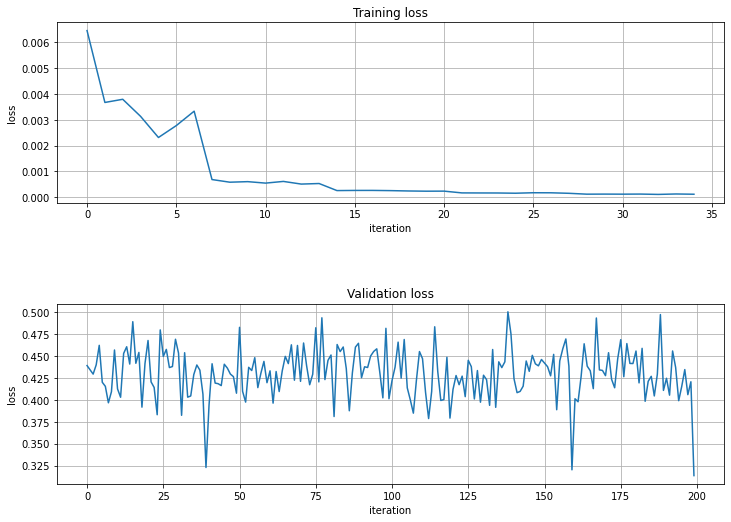

In [49]:
fig, axs = plt.subplots(2, figsize=(10,7))
#fig.suptitle('Loss over Training and Validation set')
fig.tight_layout(h_pad = 8)

axs[0].plot(metrics_mlp['loss_history'])
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].grid()
axs[0].set_title('Training loss')


axs[1].plot(metrics_mlp['loss_val'])
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
axs[1].grid()
axs[1].set_title('Validation loss')

plt.show()

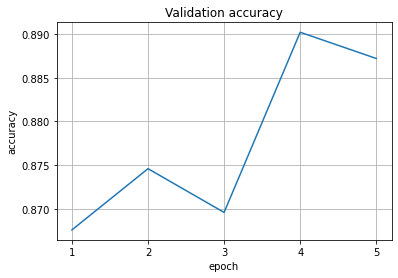

In [29]:
plt.plot(range(1, 6), metrics_mlp['acc_val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.xticks(range(1, 6))
plt.title('Validation accuracy')
plt.show()

## Question 3

In [25]:
# ELMAN NETWORK
class Elman(nn.Module):
  def __init__(self, insize=300, outsize=300, hsize=300):

    super().__init__()
    self.lin1 = nn.Linear(insize + hsize, outsize)
    self.lin2 = nn.Linear(hsize, outsize)

  def forward(self, x, hidden = None):
    b, t, e = x.size()

    if hidden is None:
      hidden = torch.zeros(b,e,dtype = torch.float).to(device=device)

    outs = []
    for i in range(t):
      inp    = torch.cat([x[:, i, :], hidden], dim=1).to(device=device)
      input  = self.lin1(inp)
      hidden = F.relu(input)
      out    = self.lin2(hidden)
      outs.append(out[:, None, :])

    return torch.cat(outs, dim =1)

In [26]:
# Replacing second layer with Elman
class MLPElman(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx, hidden_size, output_size, hidden_elman = 300) -> None:
        super().__init__()

        self.embed = nn.Embedding(num_embeddings, embedding_dim, padding_idx ,) # [batch_size, time] -> [batch_size, time, embedding_dim]
        self.layer1 = Elman(hidden_size, hidden_size, hidden_elman, )           # [batch_size, time, embedding_dim] -> [batch_size, time, hidden_size]
        self.layer2 = nn.Linear(hidden_size, output_size)                       # [batch_size, hidden_size] -> [batch_size, output_size]

    def forward(self, input):
        #x = input.to(device=device)
        x = self.embed(input)
        x = self.layer1(x)
        x = F.relu(x)
        #x = torch.max(x, dim=1, keepdim=True)
        x = torch.amax(x,1)
        x = self.layer2(x)
        
        return x

In [27]:
MLPElman_model = MLPElman(num_embeddings, embedding_dim, padding_idx, hidden_size, output_size = numcls, hidden_elman = 300).to(device=device)
MLPElman_model

MLPElman(
  (embed): Embedding(99430, 300, padding_idx=0)
  (layer1): Elman(
    (lin1): Linear(in_features=600, out_features=300, bias=True)
    (lin2): Linear(in_features=300, out_features=300, bias=True)
  )
  (layer2): Linear(in_features=300, out_features=2, bias=True)
)

In [28]:
batch_t, target_t = preprocess_batch(x_train[:5], y_train[:5])
batch_t           = batch_t.to(device=device)
target_t         = target_t.to(device=device)

In [29]:
MLPElman_model(batch_t).to(device)

tensor([[-0.3483, -0.3320],
        [-0.3749, -0.4089],
        [-0.3159, -0.2094],
        [-0.3734, -0.4106],
        [-0.3483, -0.3520]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
#TRAIN
MLPElman_model                        = MLPElman(num_embeddings, embedding_dim, padding_idx, hidden_size, output_size = numcls, hidden_elman = 300).to(device =device)

In [36]:
MLPElman_model_trained, metrics_Elman = train(MLPElman_model, x_train, y_train, x_val, y_val, epochs = 5, batch_size = 128, learning_rate = 0.001)

<ipython-input-19-c8cfd633485e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data    = np.array(data)



			Accuracy of the network on the 5000 text: 85 %

			Accuracy of the network on the 5000 text: 87 %


KeyboardInterrupt: ignored

In [ ]:
torch.save(MLPElman_model_trained,'Q3_MLPElman_model.pt')

In [ ]:
fig, axs = plt.subplots(2, figsize=(10,7))
#fig.suptitle('Loss over Training and Validation set')
fig.tight_layout(h_pad = 8)

axs[0].plot(metrics_Elman['loss_history'])
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].grid()
axs[0].legend()
axs[0].set_title('Training loss')


axs[1].plot(metrics_Elman['loss_val'])
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
axs[1].grid()
axs[1].legend()
axs[1].set_title('Validation loss')

plt.show()

In [ ]:
plt.plot(range(1, 6), metrics_Elman['acc_val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.xticks(range(1, 6))
plt.title('Validation accuracy')
plt.show()

## Question 4

## RNN

     learning_rate = 0.001
     epochs        = 5
     batch_size    = 128

In [31]:
## Torch RNN
class RNN(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx, hidden_size, output_size) -> None:
        super().__init__()

        self.embed = nn.Embedding(num_embeddings, embedding_dim, padding_idx ,)                    # [batch_size, time] -> [batch_size, time, embedding_dim]
        self.layer1 = nn.RNN(hidden_size, hidden_size, batch_first = True, nonlinearity = 'relu' ) # [batch_size, time, embedding_dim] -> [batch_size, time, hidden_size]
        self.layer2 = nn.Linear(hidden_size, output_size)                                          # [batch_size, hidden_size] -> [batch_size, output_size]

    def forward(self, input):
        x = input
        x = x.to(device=device)
        x = self.embed(x)
        x,h = self.layer1(x)
        x = F.relu(x)
        x = torch.amax(x,1)
        x = self.layer2(x)
        
        return x

In [32]:
RNN_model   = RNN(num_embeddings, embedding_dim, padding_idx, hidden_size, output_size = numcls).to(device=device)

In [39]:
RNN_model_trained, metrics_RNN = train(RNN_model, x_train, y_train, x_val, y_val, epochs = 5, batch_size = 128, learning_rate = 0.001)
torch.save(RNN_model_trained,'Q4_RNN_model.pt')

<ipython-input-18-c8cfd633485e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data    = np.array(data)



			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %


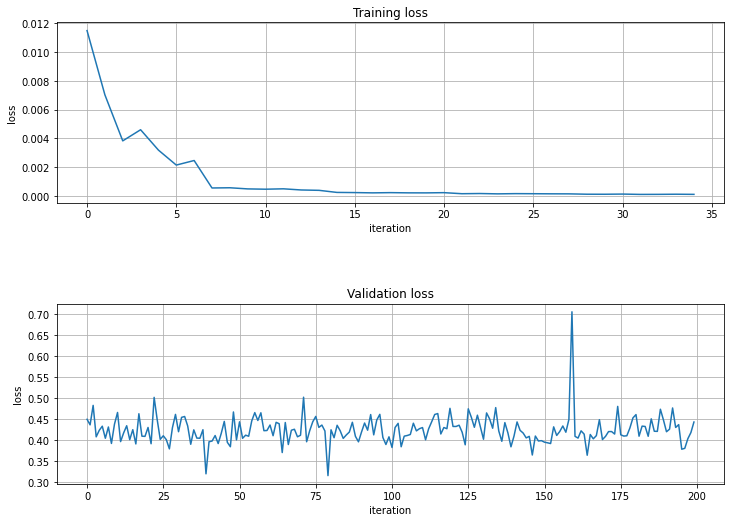

In [40]:
fig, axs = plt.subplots(2, figsize=(10,7))
#fig.suptitle('Loss over Training and Validation set')
fig.tight_layout(h_pad = 8)

axs[0].plot(metrics_RNN['loss_history'])
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].grid()
axs[0].set_title('Training loss')


axs[1].plot(metrics_RNN['loss_val'])
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
axs[1].grid()
axs[1].set_title('Validation loss')

plt.show()

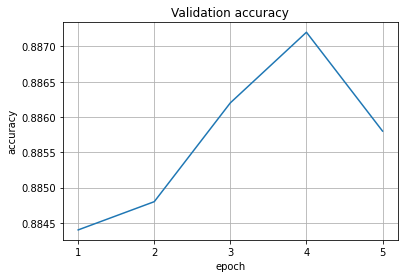

In [41]:
plt.plot(range(1, 6), metrics_RNN['acc_val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.xticks(range(1, 6))
plt.title('Validation accuracy')
plt.show()

## LSTM

    learning_rate = 0.001
    epochs        = 5
    batch_size    = 128

In [33]:
## LSTM
class RNNLSTM(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx, hidden_size, output_size) -> None:
        super().__init__()

        self.embed = nn.Embedding(num_embeddings, embedding_dim, padding_idx ,) # [batch_size, time] -> [batch_size, time, embedding_dim]
        self.layer1 = nn.LSTM(hidden_size, hidden_size, batch_first = True) # [batch_size, time, embedding_dim] -> [batch_size, time, hidden_size]
        self.layer2 = nn.Linear(hidden_size, output_size) # [batch_size, hidden_size] -> [batch_size, output_size]

    def forward(self, input):
        x = input
        x = x.to(device=device)
        x = self.embed(x)
        x , h = self.layer1(x)
        x = F.relu(x)
        x = torch.amax(x,1)
        x = self.layer2(x)
        
        return x

In [34]:
LSTM_model   = RNNLSTM(num_embeddings, embedding_dim, padding_idx, hidden_size, output_size=numcls).to(device =device)

In [42]:
LSTM_model_trained, metrics_LSTM = train(LSTM_model, x_train, y_train, x_val, y_val, epochs=5, batch_size=128, learning_rate=0.001)
torch.save(LSTM_model_trained, 'Q4_LSTM_model.pt')

<ipython-input-18-c8cfd633485e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data    = np.array(data)



			Accuracy of the network on the 5000 text: 89 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %


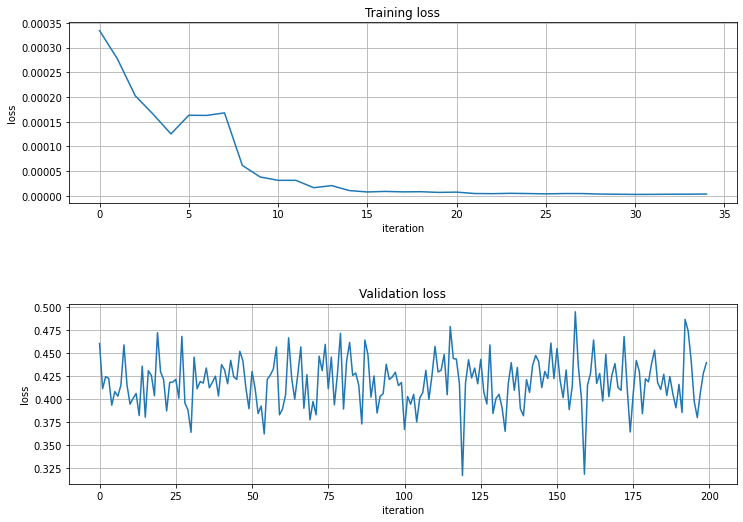

In [43]:
fig, axs = plt.subplots(2, figsize=(10,7))
#fig.suptitle('Loss over Training and Validation set')
fig.tight_layout(h_pad = 8)

axs[0].plot(metrics_LSTM['loss_history'])
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].grid()
axs[0].set_title('Training loss')


axs[1].plot(metrics_LSTM['loss_val'])
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
axs[1].grid()
axs[1].set_title('Validation loss')

plt.show()

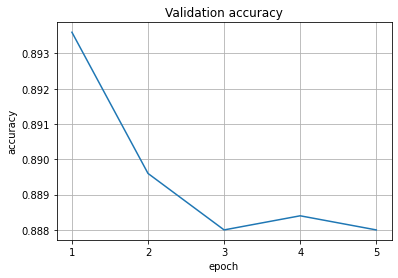

In [44]:
plt.plot(range(1, 6), metrics_LSTM['acc_val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.xticks(range(1, 6))
plt.title('Validation accuracy')
plt.show()

#Performance of LSTM, RNN, and MLP

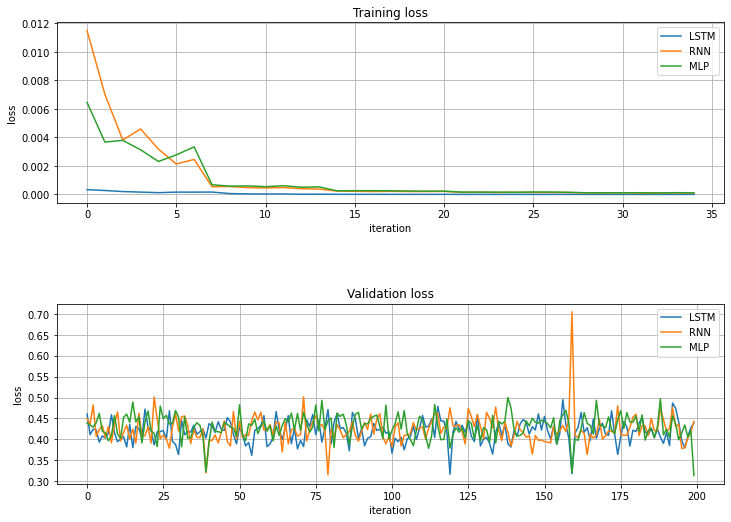

In [50]:
fig, axs = plt.subplots(2, figsize=(10,7))
#fig.suptitle('Loss over Training and Validation set')
fig.tight_layout(h_pad = 8)

axs[0].plot(metrics_LSTM['loss_history'], label = 'LSTM')
axs[0].plot(metrics_RNN['loss_history'], label = 'RNN')
axs[0].plot(metrics_mlp['loss_history'], label = 'MLP')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[0].grid()
axs[0].set_title('Training loss')


axs[1].plot(metrics_LSTM['loss_val'], label = 'LSTM')
axs[1].plot(metrics_RNN['loss_val'], label  = 'RNN')
axs[1].plot(metrics_mlp['loss_val'], label  = 'MLP')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
axs[1].legend()
axs[1].grid()
axs[1].set_title('Validation loss')

plt.legend()
plt.show()



*   A spike in the performance of RNN on validation set in the last iteration



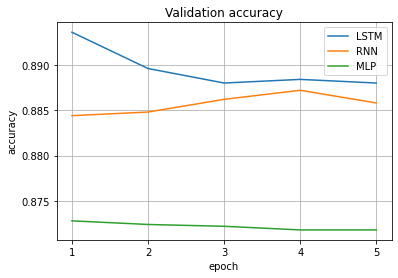

In [51]:
plt.plot(range(1, 6), metrics_LSTM['acc_val'], label = "LSTM")
plt.plot(range(1, 6), metrics_RNN['acc_val'], label  = "RNN")
plt.plot(range(1, 6), metrics_mlp['acc_val'], label  = "MLP")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.xticks(range(1, 6))
plt.title('Validation accuracy')
plt.legend()
plt.show()

# Prediction on Test Set

In [52]:
#LOAD TEST SET
(x_train_full, y_train_full), (x_test, y_test), (i2w_, w2i_), numcls_ = load_imdb(final = True)

In [53]:
def predict(model, x_test, y_test, batch_size = 128):
  correct, total = 0, 0
  metrics        = {'loss_test':[], 'acc_test':[]}
  criterion      = nn.CrossEntropyLoss()

  for i, (x_batch, y_batch) in tqdm(enumerate(batch_generator(x_test, y_test, batch_size))):
      outputs = model(x_batch).to(device=device)
      outputs = outputs.softmax(dim = -1)
      loss    = criterion(outputs, y_batch).to(device=device)
      _, predicted = torch.max(outputs, -1)
      total += y_batch.size(0)
      correct += (predicted == y_batch).sum().item()

      metrics['loss_test'].append(loss.item())

  metrics['acc_test'].append(correct / total)

  print(f'\n\t\t\tAccuracy of the network on the {total} text from the test set: {100 * correct // total} %')

  return metrics

### Predict

In [54]:
print("LSTM\n")
metrics_test_LSTM = predict(LSTM_model_trained, x_test, y_test)
print("RNN\n")
metrics_test_RNN  = predict(RNN_model_trained, x_test, y_test)
print("MLP\n")
metrics_test_MLP  = predict(mlp_model_trained, x_test, y_test)

LSTM



0it [00:00, ?it/s]<ipython-input-18-c8cfd633485e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data    = np.array(data)
196it [00:14, 13.88it/s]



			Accuracy of the network on the 25000 text from the test set: 87 %
RNN



196it [00:38,  5.16it/s]



			Accuracy of the network on the 25000 text from the test set: 87 %
MLP



196it [00:03, 51.89it/s]


			Accuracy of the network on the 25000 text from the test set: 86 %


### Performace on test set comparison

In [55]:
performance = {'LSTM' : metrics_test_LSTM['acc_test'], 'RNN' : metrics_test_RNN['acc_test'], 'MLP' : metrics_test_MLP['acc_test']}
dict(sorted(performance.items(), key=lambda item:item[1], reverse = True)) #MLP : 0.86

{'LSTM': [0.87636], 'RNN': [0.8726], 'MLP': [0.86452]}

## Hyper-parameter Tuning

## Validation accuracy for MLP, Elman and LSTM **

    epochs       = 5
    learing_rate = 0.005

In [56]:
trained_MLP_1, metrics_mlp_1  = train(mlp_model, x_train, y_train, x_val, y_val, epochs=5, batch_size=128, learning_rate=0.005)
trained_RNN_1, metrics_RNN_1  = train(RNN_model, x_train, y_train, x_val, y_val, epochs=5, batch_size=128, learning_rate=0.005)
trained_LSTM_1,metrics_LSTM_1 = train(LSTM_model, x_train, y_train, x_val, y_val, epochs=5, batch_size=128, learning_rate=0.005)

<ipython-input-18-c8cfd633485e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data    = np.array(data)



			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %

			Accuracy of the network on the 5000 text: 88 %


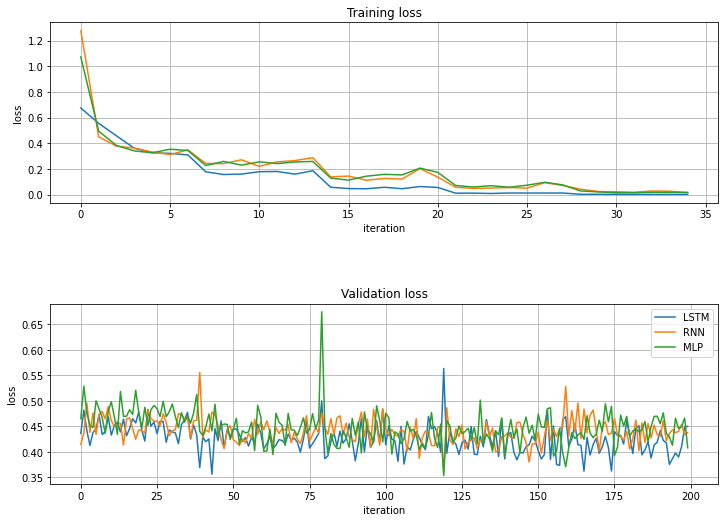

In [36]:
fig, axs = plt.subplots(2, figsize=(10,7))
#fig.suptitle('Loss over Training and Validation set')
fig.tight_layout(h_pad = 8)

axs[0].plot(metrics_LSTM_1['loss_history'], label = 'LSTM')
axs[0].plot(metrics_RNN_1['loss_history'], label = 'RNN')
axs[0].plot(metrics_mlp_1['loss_history'], label = 'MLP')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].grid()
axs[0].set_title('Training loss')


axs[1].plot(metrics_LSTM_1['loss_val'], label = 'LSTM')
axs[1].plot(metrics_RNN_1['loss_val'], label  = 'RNN')
axs[1].plot(metrics_mlp_1['loss_val'], label  = 'MLP')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
axs[1].grid()
axs[1].set_title('Validation loss')

plt.legend()
plt.show()

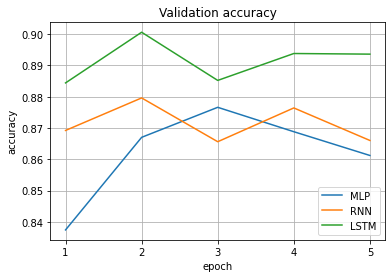

In [37]:
plt.plot(range(1, 6), metrics_mlp_1['acc_val'], label = 'MLP')
plt.plot(range(1, 6), metrics_RNN_1['acc_val'], label = 'RNN')
plt.plot(range(1, 6), metrics_LSTM_1['acc_val'], label = 'LSTM')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.xticks(range(1, 6))
plt.title('Validation accuracy')
plt.show()

In [57]:
print("LSTM\n")
metrics_test_LSTM_1 = predict(trained_LSTM_1, x_test, y_test)
print("RNN\n")
metrics_test_RNN_1  = predict(trained_RNN_1, x_test, y_test)
print("MLP\n")
metrics_test_MLP_1  = predict(trained_MLP_1, x_test, y_test)

performance = {'LSTM' : metrics_test_LSTM_1['acc_test'], 'RNN' : metrics_test_RNN_1['acc_test'], 'MLP' : metrics_test_MLP_1['acc_test']}
dict(sorted(performance.items(), key=lambda item:item[1], reverse = True))

LSTM



0it [00:00, ?it/s]<ipython-input-18-c8cfd633485e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data    = np.array(data)
196it [00:13, 14.02it/s]



			Accuracy of the network on the 25000 text from the test set: 87 %
RNN



196it [00:38,  5.15it/s]



			Accuracy of the network on the 25000 text from the test set: 87 %
MLP



196it [00:03, 52.31it/s]


			Accuracy of the network on the 25000 text from the test set: 86 %


{'LSTM': [0.87084], 'RNN': [0.87], 'MLP': [0.8606]}

## Validation accuracy for MLP, Elman and LSTM
     
     epochs       = 15
     learing_rate = 0.0001

In [58]:
trained_MLP_3,  metrics_mlp_3   = train(mlp_model, x_train, y_train, x_val, y_val, epochs=10, batch_size=128, learning_rate=0.0001)
trained_RNN_3,  metrics_RNN_3   = train(RNN_model, x_train, y_train, x_val, y_val, epochs=10, batch_size=128, learning_rate=0.0001)
trained_LSTM_3, metrics_LSTM_3  = train(LSTM_model, x_train, y_train, x_val, y_val, epochs = 10, batch_size = 128, learning_rate = 0.0001)

<ipython-input-18-c8cfd633485e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data    = np.array(data)



			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %

			Accuracy of the network on the 5000 text: 87 %


KeyboardInterrupt: ignored

In [ ]:
plt.plot(range(1, 11), metrics_mlp_3['acc_val'], label = 'MLP')
plt.plot(range(1, 11), metrics_RNN_3['acc_val'], label = 'RNN')
plt.plot(range(1, 11), metrics_LSTM_3['acc_val'], label = 'LSTM')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.xticks(range(1, 11))
plt.title('Validation accuracy')
plt.show()

In [ ]:
print("LSTM\n")
metrics_test_LSTM_3 = predict(trained_LSTM_3, x_test, y_test)
print("RNN\n")
metrics_test_RNN_3  = predict(trained_RNN_3, x_test, y_test)
print("MLP\n")
metrics_test_MLP_3  = predict(trained_MLP_3, x_test, y_test)

In [ ]:
performance = {'LSTM' : metrics_test_LSTM_3['acc_test'], 'RNN' : metrics_test_RNN_3['acc_test'], 'MLP' : metrics_test_MLP_3['acc_test']}
dict(sorted(performance.items(), key=lambda item:item[1], reverse = True))